1 — Install & Imports

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.nn.functional import sigmoid

import matplotlib.pyplot as plt


2 — Paths

In [2]:
DATA_DIR = "../data/HAM10000_images"
META_CSV = "../data/HAM10000_metadata.csv"

print("DATA_DIR:", DATA_DIR)
print("META_CSV:", META_CSV)

assert os.path.isdir(DATA_DIR), "Image directory not found"
assert os.path.isfile(META_CSV), "Metadata CSV not found"


DATA_DIR: ../data/HAM10000_images
META_CSV: ../data/HAM10000_metadata.csv


3 — Load Metadata + Risk Mapping

In [3]:
df = pd.read_csv(META_CSV)
print("Original rows:", len(df))
df.head()


Original rows: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
risk_map = {
    "mel": 1,   # melanoma - high risk
    "bcc": 1,   # basal cell carcinoma - high risk
    "akiec": 1, # actinic keratoses - high risk
    "nv": 0,    # nevus - low risk
    "bkl": 0,   # benign keratosis - low risk
    "df": 0,    # dermatofibroma - low risk
    "vasc": 0   # vascular lesions - low risk
}

df["risk_label"] = df["dx"].map(risk_map)

print("Class counts (full dataset):")
print(df["risk_label"].value_counts())
print("Class ratio (full dataset):")
print(df["risk_label"].value_counts(normalize=True))

Class counts (full dataset):
risk_label
0    8061
1    1954
Name: count, dtype: int64
Class ratio (full dataset):
risk_label
0    0.804893
1    0.195107
Name: proportion, dtype: float64


4 — Remove Missing Images

In [5]:
def image_exists(image_id):
    return os.path.isfile(os.path.join(DATA_DIR, image_id + ".jpg"))

df = df[df["image_id"].apply(image_exists)]
print("Rows after filtering:", len(df))


Rows after filtering: 5114


5 — Create Balanced Subset

In [6]:
print("Dataset before subset:", len(df))
N_PER_CLASS = 800

subset_df = (
    df.groupby("risk_label", group_keys=False)
      .apply(lambda g: g.sample(n=min(N_PER_CLASS, len(g)), random_state=42))
)

print("Subset size:", len(subset_df))
print(subset_df["risk_label"].value_counts())


Dataset before subset: 5114
Subset size: 1600
risk_label
0    800
1    800
Name: count, dtype: int64


/tmp/ipykernel_36225/2353740886.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(N_PER_CLASS, len(g)), random_state=42))


6 — Train/Val/Test Split (Stratified)

In [7]:
train_df, temp_df = train_test_split(
    subset_df,
    test_size=0.30,
    stratify=subset_df["risk_label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["risk_label"],
    random_state=42,
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 1120
Val: 240
Test: 240


7 — Transforms + Dataset

In [8]:
IMG_SIZE = 160
BATCH_SIZE = 16

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [9]:
class HamDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"] + ".jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row["risk_label"], dtype=torch.float32)
        return image, label


8 — Loaders

In [10]:
train_dataset = HamDataset(train_df, DATA_DIR, train_transform)
val_dataset   = HamDataset(val_df, DATA_DIR, eval_transform)
test_dataset  = HamDataset(test_df, DATA_DIR, eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


9 — Model: ResNet18 (CPU-Friendly)

In [12]:
device = torch.device("cpu")
device


device(type='cpu')

In [13]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
model.fc


25.2%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


Linear(in_features=512, out_features=1, bias=True)

10 — Loss + Optimizer

In [14]:
train_counts = Counter(train_df["risk_label"])
pos_weight_value = train_counts[0] / max(train_counts[1], 1)

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_value], device=device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 6

train_counts, pos_weight_value


(Counter({1: 560, 0: 560}), 1.0)

11 — Training & Eval Helpers

In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = (sigmoid(logits) >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


In [16]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    y_true, y_prob = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images).squeeze(1)
            loss = criterion(logits, labels)
            running_loss += loss.item() * labels.size(0)

            probs = sigmoid(logits)
            preds = (probs >= 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    
    return running_loss / total, correct / total, np.array(y_true), np.array(y_prob)


12 — Training Loop

In [17]:
best_val_loss = float("inf")
train_history = []
val_history = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../best_resnet18_triage.pth")

model.load_state_dict(torch.load("../best_resnet18_triage.pth"))


Epoch 1/6 Train Loss: 0.5259 Acc: 0.7411 Val Loss: 0.4445 Acc: 0.7833
Epoch 2/6 Train Loss: 0.4504 Acc: 0.7679 Val Loss: 0.4047 Acc: 0.8208
Epoch 3/6 Train Loss: 0.3997 Acc: 0.8250 Val Loss: 0.5150 Acc: 0.7958
Epoch 4/6 Train Loss: 0.3609 Acc: 0.8304 Val Loss: 0.4246 Acc: 0.8250
Epoch 5/6 Train Loss: 0.3136 Acc: 0.8518 Val Loss: 0.4904 Acc: 0.8000
Epoch 6/6 Train Loss: 0.2846 Acc: 0.8759 Val Loss: 0.5397 Acc: 0.8000


<All keys matched successfully>

13 — Learning Curves

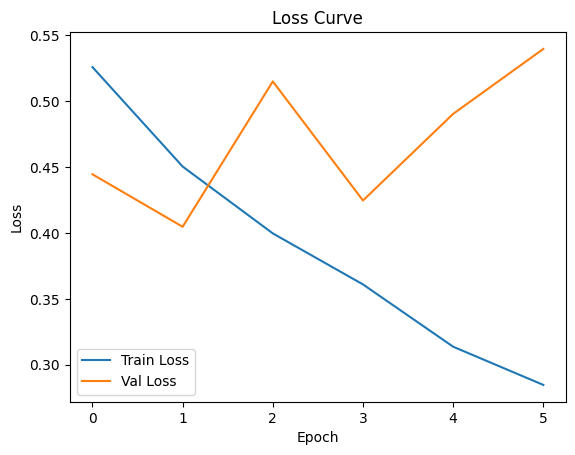

In [18]:
train_losses = [x[0] for x in train_history]
val_losses   = [x[0] for x in val_history]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


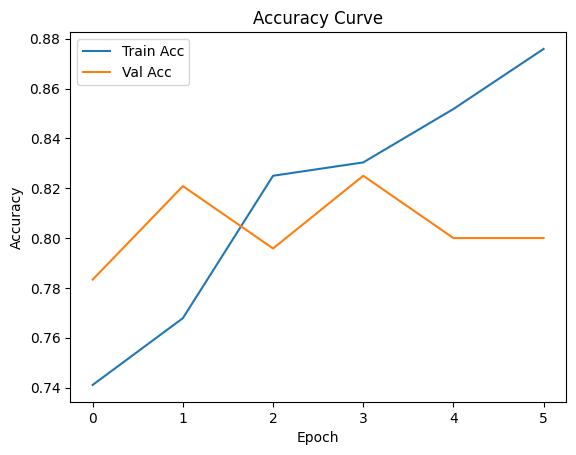

In [19]:
train_accs = [x[1] for x in train_history]
val_accs   = [x[1] for x in val_history]

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


14 — Test Evaluation

In [20]:
test_loss, test_acc, y_true, y_prob = evaluate(model, test_loader, criterion, device)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred, target_names=["Low Risk", "High Risk"]))


Test Loss: 0.4668027440706889
Test Accuracy: 0.7916666666666666
              precision    recall  f1-score   support

    Low Risk       0.78      0.81      0.80       120
   High Risk       0.80      0.78      0.79       120

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240



15 — Confusion Matrix

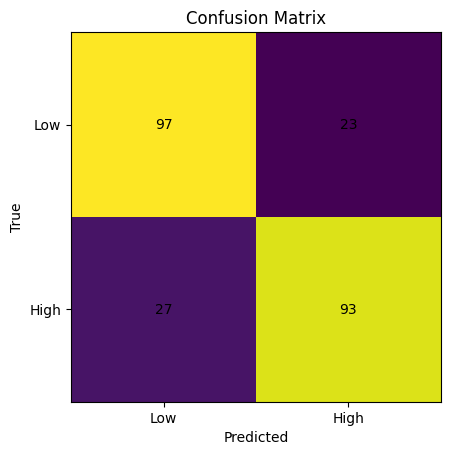

In [21]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
ax.imshow(cm)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Low", "High"])
ax.set_yticklabels(["Low", "High"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j], ha="center", va="center")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


16 — ROC Curve

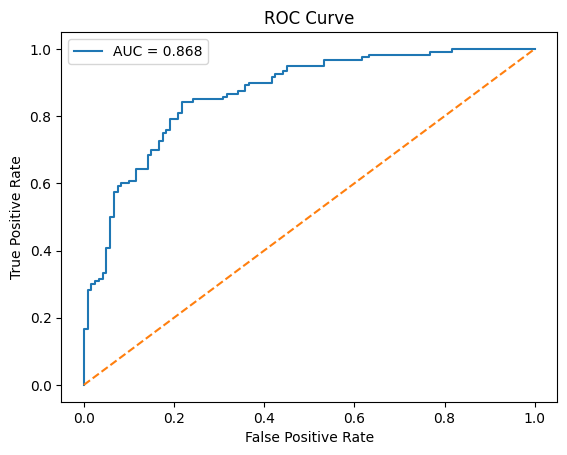

In [22]:
roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
